In [3]:
import os
%env OPENAI_API_KEY=token
%env REPLICATE_API_TOKEN=token

print(os.environ.get("OPENAI_API_KEY"))

env: OPENAI_API_KEY=token
env: REPLICATE_API_TOKEN=token
token


[INFO] [1745694427.942092, 162.879000]: Waiting for joint trajectory action on /locobot/arm_controller/follow_joint_trajectory…
[INFO] [1745694428.250725, 162.937000]: Joint‐space action server ready


[WARN] [1745694428.591398187]: Link 'locobot/caster_back_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.593979650]: Link 'locobot/caster_front_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594045399]: Link 'locobot/wheel_left_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594071976]: Link 'locobot/wheel_right_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594101653]: Link 'locobot/caster_back_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594126683]: Link 'locobot/caster_front_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594157032]: Link 'locobot/wheel_left_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594181494]: Link 'locobot/wheel_right_link' is not known to URDF. Cannot disable/enable collisons.
[WARN] [1745694428.594208702]: Link 'locobot/caster_back

[INFO] [1745694428.596189378]: Loading robot model 'locobot'...
[INFO] [1745694428.596222977]: No root/virtual joint specified in SRDF. Assuming fixed joint
[INFO] [1745694431.797120205, 163.520000000]: Ready to take commands for planning group interbotix_arm.
[INFO] [1745694439.192543, 164.521000]: LocobotArmControl initialized


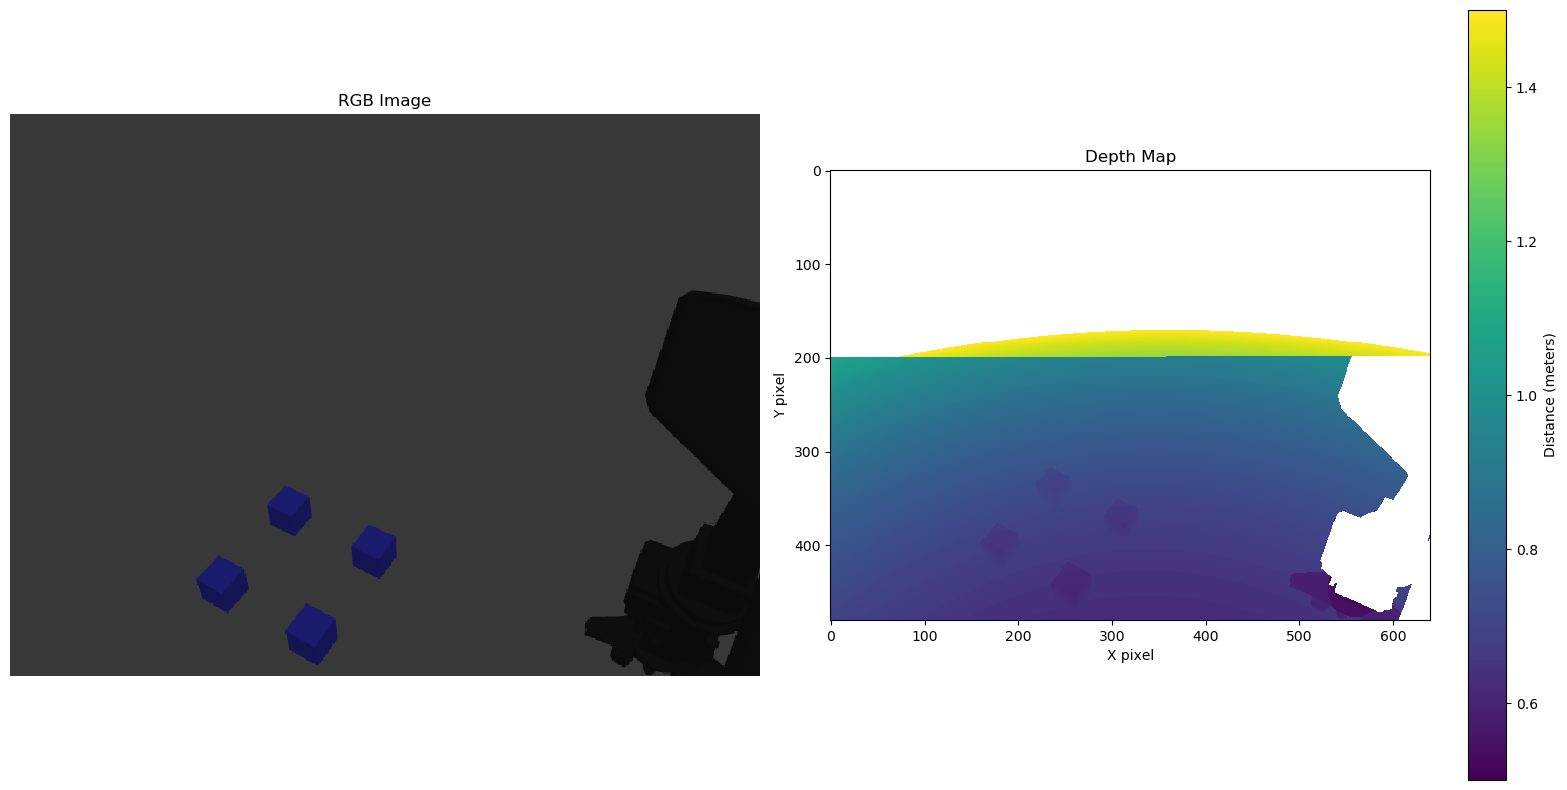

Using OpenAI API with model gpt-4o
Sending prompt to OpenAI...
Base response received.
To build the target structure, a simple house shape with a square base and a triangular roof, we'll use the blocks as follows:

1. **Deconstructed Plan:**
   - Base of the house: A 2x2 square placed on the grid.
   - Roof of the house: Two blocks to form a triangle above the square.

2. **Build Coordinates:**
   - Base: Use blocks positioned at (4,0), (5,0), (4,1), (5,1).
   - Roof: Use blocks positioned at (4,2) and (5,2).

3. **Step by Step Instructions:**

**Action 1**: 
```plaintext
{ pos_init: {x: 0, y: 0}, pos_finale: {x: 4, y: 0}, notice: "Place the leftmost base block." }
```

**Action 2**: 
```plaintext
{ pos_init: {x: 1, y: 0}, pos_finale: {x: 5, y: 0}, notice: "Place the rightmost base block." }
```

**Action 3**: 
```plaintext
{ pos_init: {x: 0, y: 1}, pos_finale: {x: 4, y: 1}, notice: "Place the left block above the first base block." }
```

**Action 4**: 
```plaintext
{ pos_init: {x: 1,

AttributeError: 'LocobotCamera' object has no attribute 'get_target_coordinate_from_camera'

In [2]:
#roslaunch locobot_connector cube_spawner.launch num_cubes:=4 positions:=[[0.30,0.25,0.01],[0.30,0.35,0.01],[0.4,0.25,0.01],[0.4,0.35,0.01]]
import numpy as np
import matplotlib.pyplot as plt
from visioncraft.locobot.camera import LocobotCamera
from visioncraft.locobot.arm_control import LocobotArmControl
import rospy
from visioncraft.vlm.vlm_pipeline import VLMPipeline
import os

def visualize_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Create a depth map visualization and show the RGB image using matplotlib
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot RGB image
    axs[0].imshow(img)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    

    # Plot depth map
    depth_plot = axs[1].imshow(depth_map, cmap='viridis')
    axs[1].set_title('Depth Map')
    axs[1].set_xlabel('X pixel')
    axs[1].set_ylabel('Y pixel')
    fig.colorbar(depth_plot, ax=axs[1], label='Distance (meters)')
    
    plt.tight_layout()
    plt.show()

def get_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Get the depth map from the camera
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    return depth_map, height, width

def pick_block_action(action, cam, arm_control):
    print(f"Action: {action}")
    pos_init = action['pos_init']
    depth_map, height, width = get_depth_map(cam)
    x = int(pos_init["x"]/100 * width)
    y = int(pos_init["y"]/100 * height)
    go_to_pos(cam, arm_control, x, y)
    print(f"X: {x}, Y: {y}")
    if depth_map[y, x] is not None:
        print(f"Distance: {depth_map[y, x]} m")
    else:
        print("No valid distance found at this pixel.")

def go_to_pos(cam,arm_control, x, y):

    img = cam.get_image()

    point_camera = cam.get_point_at_pixel(x, y)
    point_base = cam.get_target_coordinate_from_camera(point_camera)
    arm_control.pick(point_base)

def place_block_action(action, cam):
    print(f"Action: {action}")
    pass

def main():
    cam = LocobotCamera()
    arm_control = LocobotArmControl()

    cam.pan(0.5)
    cam.tilt(0.7)
    img = cam.get_image()
        
    # Visualize depth map and image
    visualize_depth_map(cam)
    plt.imsave('../resources/rgb_image.png', img)

    vlm_pipeline = VLMPipeline(model_name="gpt-4o", openai_api_key=os.environ.get("OPENAI_API_KEY"))
    vlm_pipeline.set_current_image("../resources/rgb_image.png")
    vlm_pipeline.set_goal_image("../resources/simple_house.png")
    json_answer = vlm_pipeline.run_pipeline()
    for actions in json_answer:
            for action in json_answer[actions]:
                # Each action to accomplish
                pick_block_action(action, cam, arm_control)
                

    # Wait for some data to be received
    rospy.sleep(1.0)


if __name__ == '__main__':
    main()
